In [6]:
from pylab import *
from numpy import *
%matplotlib inline
from matplotlib import gridspec

Programamos de nuevo runge-kutta de 4to orden con 2 argumentos (modelo de fricción y ángulo de inclinación)

In [7]:
def rk4(ec,p_ini,x,args1=0,args2=0,h=0.01):
    if (x[1]-x[0]) <= 5.*h:
        h = (x[1]-x[0])/10
    tiempos = arange(x[0],x[1]+h,h)
    sol = zeros((len(tiempos),len(p_ini)))
    sol[0,:] = p_ini
    if args1==0:
        if args2==0:
            for i in range(len(tiempos)-1):
                k1 = ec(sol[i,:],tiempos[i])
                k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h)
                k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h)
                k4 = ec(sol[i,:]+h*k3,tiempos[i]+h)
                sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4)
        else:
            for i in range(len(tiempos)-1):
                k1 = ec(sol[i,:],tiempos[i])
                k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h,0,args2)
                k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h,0,args2)
                k4 = ec(sol[i,:]+h*k3,tiempos[i]+h,0,args2)
                sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4)
    else:
        if args2==0:
            for i in range(len(tiempos)-1):
                k1 = ec(sol[i,:],tiempos[i],args1)
                k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h,args1)
                k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h,args1)
                k4 = ec(sol[i,:]+h*k3,tiempos[i]+h,args1)
                sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4)
        else:
            for i in range(len(tiempos)-1):
                k1 = ec(sol[i,:],tiempos[i],args1,args2)
                k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h,args1,args2)
                k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h,args1,args2)
                k4 = ec(sol[i,:]+h*k3,tiempos[i]+h,args1,args2)
                sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4) 
    return tiempos,sol

Programamos ahora la ecuación de movimiento. Tomamos como sistema de referencia a aquel que tiene el eje x paralelo a la superficie del plano. La ecuación de movimiento de la pelota puede ser obtenida a partir de la ecuación para el sistema convencional a partir de una rotación. Las componentes de un vector en el sistema rotado se expresan en términos de las compontentes en el sistema no rotado como:

 $$
 x = xcos\alpha-ysen\alpha
 $$
 
 $$
  y = ycos\alpha+xsen\alpha
 $$
 
 Tomando en cuenta esto, la gravedad en el sistema rotado es $\vec g = (g/m)sen\alpha \hat{e_x}-(g/m)cos\alpha \hat{e_y}$

In [38]:
def rotacion(x,a):
    xrot =zeros(4)
    xrot[0] = x[0]*cos(a)+sin(a)*x[1]
    xrot[1] = x[1]*cos(a)-sin(a)*x[0]
    xrot[2] = x[2]*cos(a)+sin(a)*x[3]
    xrot[3] = x[3]*cos(a)-sin(a)*x[2]
    return xrot

In [85]:
def e_mov(r_v,t,fric=0,a=0,g=9.8,m=1): #r_v contiene a las coordenadas x y y y a las velocidades, a es el ángulo de inclinación del plano
    u = sqrt(r_v[2]**2 + r_v[3]**2)
    dx = r_v[2]
    dy = r_v[3]
    if fric == 0:
        if a==0:
            dvx,dvy = 0,-(g/m)
        else:
            dvx,dvy = rotacion([0,0,0, -(g/m)],-a)[2], rotacion([0,0,0, -(g/m)],-a)[3]
    else:
        if a==0:
            dvx = - fric([r_v[2],r_v[3]])[0]
            dvy = -(g/m) - fric([r_v[2],r_v[3]])[1]
        else:
            dvx = - fric([r_v[2],r_v[3]])[0]
            dvy = rotacion([0,0,0, -(g/m)],-a)[3] - fric([r_v[2],r_v[3]])[1]
    return array([dx,dy,dvx,dvy])

In [86]:
def rebote(r_v_i,mi_dt):
    dt_busqueda = mi_dt/2.
    y_izq = r_v_i
    t,sol = rk4(e_mov,r_v_i,[0,dt_busqueda],fric_v)
    y_med = sol[-1,:]
    while abs(y_izq[1]) > 1e-5:
        if y_izq[1]*y_med[1] < 0:
            reinicio = y_izq
        else:
            reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t,sol = rk4(e_mov,reinicio,[0,dt_busqueda],fric_v)
        y_izq = reinicio
        y_med = sol[-1,:]
    y_izq = array([y_izq[0],y_izq[1],y_izq[2],-y_izq[3]])    
    return y_izq

In [87]:
def fric_v(v,gamma=0.1):
    f_x = gamma*v[0]
    f_y = gamma*v[1]
    return array([f_x,f_y]) 

def fric_v2(v,gamma=0.1):
    norm_v = sqrt(v[0]**2 + v[1]**2)
    f_x = gamma*norm_v*v[0]
    f_y = gamma*norm_v*v[1]
    return array([f_x,f_y]) 

In [104]:
def trayec(p_ini,pasos,a,friccion,mi_dt = .1):
    a=a*pi/180
    trayectoria = zeros((N,4))
    trayectoria_la_buena = zeros((N,4))
    trayectoria[0,:] = array(rotacion(p_ini,-a))  #Condiciones iniciales en el sistema rotado
    trayectoria_la_buena[0,:] = array(p_ini)
    for i in range(N-1):
        t,sol_dt = rk4(e_mov,trayectoria[i,:],[0,mi_dt],friccion,-a,h=0.01)  
        if sol_dt[-1,:][1] < 0:
            punto = rebote(trayectoria[i,:],mi_dt)
            trayectoria[i+1,:] = punto
        else:
            trayectoria[i+1,:] = sol_dt[-1,:]   #Resuelve el problema en el sistema rotado
    for j in range(len(trayectoria[:,0])):
        b  = rotacion(trayectoria[j,:],a) #Rotamos nuevamente al sistema original
        trayectoria_la_buena[j,:]= b
    return trayectoria_la_buena


Tenemos ya la solución en el marco rotado; ahora sólo debemos de rotarla al marco original para poder graficarla. Esto se hace haciendo el inverso de la transformación de antes:
$$
x_0= xcos \alpha +ysen \alpha
$$
$$
y_0= ycos \alpha -xsen \alpha
$$

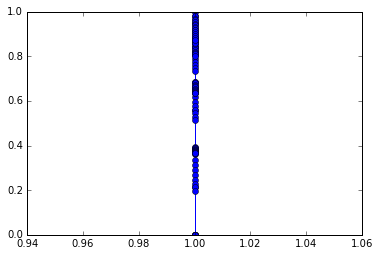

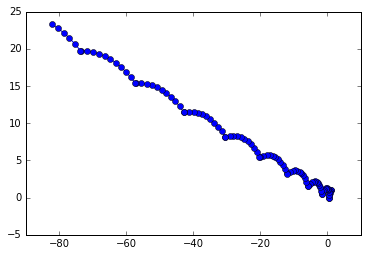

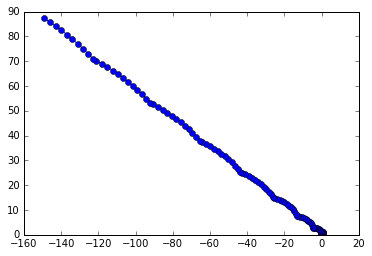

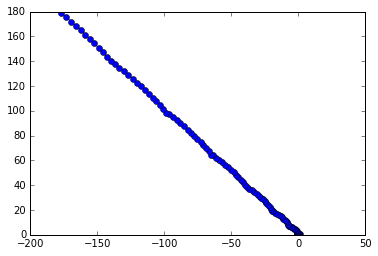

In [110]:
angulos = [0,15 ,30 ,45]
for i in range(len(angulos)):
    trayectoria1 =trayec([1,1,0,0],50,angulos[i],0)
    plot(trayectoria1[:,0],trayectoria1[:,1],'o-')
    show()



In [76]:
t =trayec([1,1,1,1],50,10,0)
print(t)

TypeError: 'numpy.ndarray' object is not callable